In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from datetime import datetime, timedelta
import yfinance as yf
from torch.utils.data import DataLoader

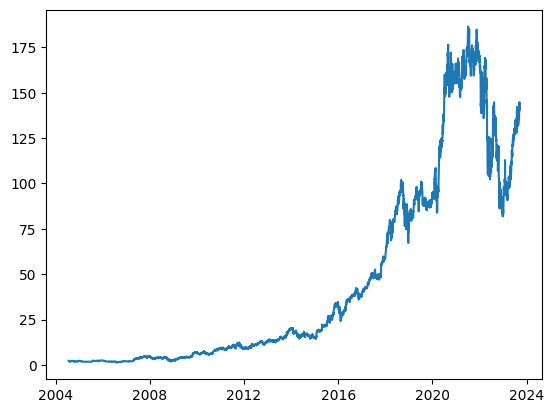

In [14]:
# Calculate the date that was 7000 days ago from today
start_date = datetime.now() - timedelta(days=7000)

# Define the ticker symbol for Amazon
ticker_symbol = 'AMZN'

# Get the stock data using yfinance library, which allows you to access stock market data from Yahoo Finance
amazon_stock_data = yf.Ticker(ticker_symbol)

# Get the historical stock data for Amazon starting from 7000 days ago until today
data = amazon_stock_data.history(start=start_date.strftime('%Y-%m-%d'))

# Resetting the index to have 'Date' in the columns rather than the index
data.reset_index(inplace=True)

# Formatting the 'Date' column to a simpler 'Year-Month-Day' format
data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')

# Selecting only the 'Date' and 'Close' columns for our analysis
data = data[['Date', 'Close']]

# Checking if CUDA is available for PyTorch, and setting the device accordingly
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Converting the 'Date' column to datetime format to facilitate time series analysis
data['Date'] = pd.to_datetime(data['Date'])

# Plotting the closing prices over time
# 'Date' is on the x-axis and 'Close' prices on the y-axis
plt.plot(data['Date'], data['Close'])

# Display the plot
plt.show()


In [15]:
# Define a function to prepare the dataframe for LSTM by creating lag features
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df) # Creating a deep copy of the dataframe to avoid altering the original dataframe

    # Setting 'Date' column as the index
    df.set_index('Date', inplace=True)

    # Creating lag features using a loop to shift the 'Close' column 'n_steps' times
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    # Removing rows with NaN values that were introduced during the creation of lag features
    df.dropna(inplace=True)

    return df

# Define the lookback period
lookback = 7

# Prepare the dataframe using the defined function
shifted_df = prepare_dataframe_for_lstm(data, lookback)

# Convert the dataframe to a numpy array
shifted_df_as_np = shifted_df.to_numpy()

# Initialize the scaler with a feature range of -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

# Scale the data
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

# Define the features (X) and target (y) variables
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

# Flip the order of the columns for the feature variables
X = dc(np.flip(X, axis=1))

# Define the index to split the data into training and test sets
split_index = int(len(X) * 0.95)

# Split the data
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

# Reshape the data to fit the LSTM input requirements
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

# Define a PyTorch dataset class for the time series data
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    # Define a method to get the total number of samples
    def __len__(self):
        return len(self.X)

    # Define a method to get a sample by index
    def __getitem__(self, i):
        return self.X[i], self.y[i]

# Create dataset objects for training and testing
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

# Define the batch size
batch_size = 16

# Create data loaders for batching the training and test datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Loop through the train loader to get a batch of data and print the shape of the x and y batch
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [16]:
batch_size = 16

# Creating data loaders with defined batch size; training data is shuffled each epoch while testing data is not
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Looping through the train loader once to retrieve and print the shape of a single batch of data
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

# Defining the LSTM neural network class
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()  # Calling the superclass initializer
        self.hidden_size = hidden_size  # Number of hidden units per layer
        self.num_stacked_layers = num_stacked_layers  # Number of stacked LSTM layers

        # Defining the LSTM layer with specified input size, hidden size, and number of layers; enabling batch first option
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)

        # Defining a fully connected (linear) layer to map the LSTM output to a single output value
        self.fc = nn.Linear(hidden_size, 1)

    # Defining the forward method to detail how input data (x) is processed through the network layers
    def forward(self, x):
        batch_size = x.size(0)  # Retrieving the batch size from the input tensor

        # Initializing hidden state and cell state tensors with zeros
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        # Passing the input data and initial states through the LSTM layer; discarding the new states
        out, _ = self.lstm(x, (h0, c0))

        # Using the final hidden state from the LSTM layer as input to the fully connected layer to get the output
        out = self.fc(out[:, -1, :])
        return out

# Creating an instance of the LSTM class with specific dimensions
model = LSTM(1, 4, 1)

# Transferring the model to the GPU if available
model.to(device)
model

torch.Size([16, 7, 1]) torch.Size([16, 1])


LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [17]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('-----------------------------')
    print()

Epoch: 1
Batch 100, Loss: 0.585
Batch 200, Loss: 0.268

Val Loss: 0.143
-----------------------------

Epoch: 2
Batch 100, Loss: 0.045
Batch 200, Loss: 0.020

Val Loss: 0.012
-----------------------------

Epoch: 3
Batch 100, Loss: 0.009
Batch 200, Loss: 0.006

Val Loss: 0.007
-----------------------------

Epoch: 4
Batch 100, Loss: 0.003
Batch 200, Loss: 0.002

Val Loss: 0.003
-----------------------------

Epoch: 5
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001

Val Loss: 0.003
-----------------------------

Epoch: 6
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001

Val Loss: 0.002
-----------------------------

Epoch: 7
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001

Val Loss: 0.002
-----------------------------

Epoch: 8
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001

Val Loss: 0.002
-----------------------------

Epoch: 9
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001

Val Loss: 0.002
-----------------------------

Epoch: 10
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001

Val Loss: 0.002


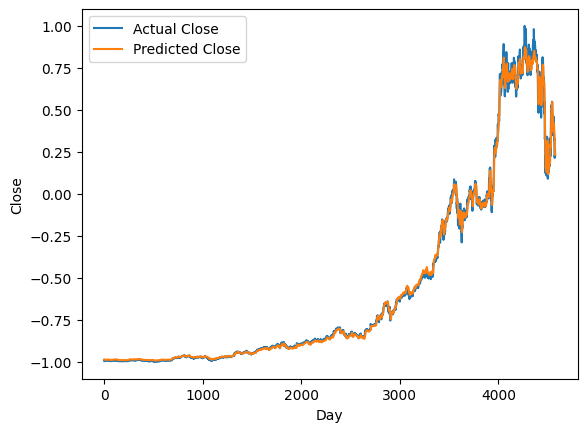

In [18]:
# Set the learning rate for the optimizer
learning_rate = 0.001

# Set the number of epochs for training the model
num_epochs = 10

# Set the loss function to Mean Squared Error Loss
loss_function = nn.MSELoss()

# Set the optimizer to Adam, a popular choice for training neural networks, with the learning rate set earlier
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Loop to train and validate the model over a fixed number of epochs
for epoch in range(num_epochs):
    # Call the function to train the model for one epoch
    train_one_epoch()

    # Call the function to validate the model using the validation dataset
    validate_one_epoch()

# Turn off gradient calculation to speed up predictions and reduce memory usage
with torch.no_grad():
    # Use the trained model to make predictions on the training dataset (it might be more informative to predict on a separate test dataset)
    predicted = model(X_train.to(device)).to('cpu').numpy()

# Plot the actual and predicted close prices over the training data
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

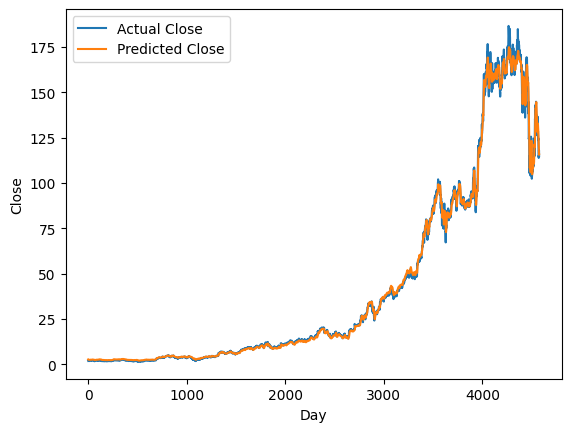

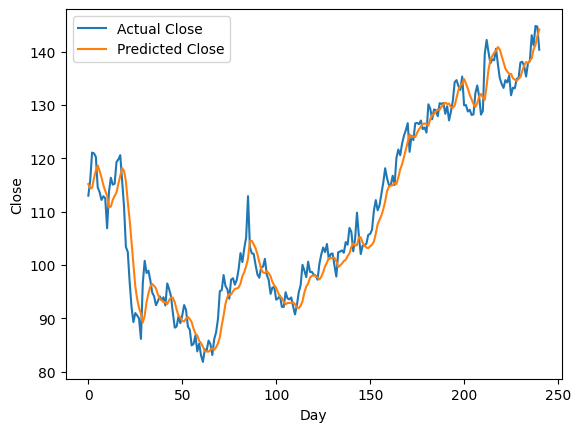

In [19]:
# Get the predicted values and flatten them to a 1D array for easy manipulation
train_predictions = predicted.flatten()

# Create a dummy array with the same number of rows as X_train and columns as lookback+1 to hold the scaled back values
dummies = np.zeros((X_train.shape[0], lookback+1))
# Assign the flattened predictions to the first column of the dummies array
dummies[:, 0] = train_predictions
# Use the MinMaxScaler's inverse_transform method to scale the predictions back to their original range
dummies = scaler.inverse_transform(dummies)
# Extract the first column which now holds the scaled back predictions
train_predictions = dc(dummies[:, 0])
train_predictions

# Repeat the process to scale back the y_train data
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)
new_y_train = dc(dummies[:, 0])
new_y_train

# Plot the actual and predicted close prices for the training data
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

# Get the model's predictions on the X_test data and flatten the resulting array for easy manipulation
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

# Create a dummy array to hold the scaled back predictions
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)
test_predictions = dc(dummies[:, 0])
test_predictions

# Create another dummy array to hold the scaled back actual y_test data
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)
new_y_test = dc(dummies[:, 0])
new_y_test

# Plot the actual and predicted close prices for the testing data
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()